## Assignment 2: System Dynamics.
**Course:** Simulation Modeling of Financial and Economic Systems <br>
**Student:** Danis Alukaev <br>
**Email:** d.alukaev@innopolis.university <br>
**Group:** B19-DS-01 <br>

### 0. Prerequisites

In [1]:
# %pip install pysd

In [1]:
import os
import pysd
import numpy as np
import pandas as pd
import torch

from tqdm import tqdm
from multiprocessing import Pool
import matplotlib.pyplot as plt
from datetime import datetime
from torch import nn
from torch.utils.data import DataLoader, Dataset
import warnings

In [2]:
warnings.filterwarnings("ignore")

### 1. Importing model

In the first step there was implemented logic for a Bass model compatible with PySD package. Further cells show how to use this model, and give somve visuals to understand it objectives: search for a market segmentation given by parameters $P_{11}$, $P_{13}$, $P_{21}$, $P_{23}$.

In [3]:
model = pysd.load('./bass.py')

In [4]:
model.doc().head()

,Real Name,Py Name,Unit,Lims,Type,Subs,Eqn,Comment
0,Competitor Customers,competitor_customers,person,"(None, None)",component,None,"INTEG(-competitor gain, 0)",
1,Competitor Customers -> Our Customers,competitor2our,person,"(None, None)",component,None,luring_threshold * efficiency_word_of_mouth * ...,
2,Competitor Customers -> Potential Customers,competitor2potential,person,"(None, None)",component,None,competitor_customers * p23 * share_dissatisfied,
3,Concentration of Potential Customers,potential_customers_concentration,float,"(None, None)",component,None,Potential Customers / Total Market,
4,Demand from Marketing,marketing_demand,person,"(None, None)",component,None,Efficiency Marketing / Potential Customers,


In [5]:
def run_model(model, params=None, return_columns=None):
    """
    Method that simulates the system dynamics using Bass model.
    The model is flexible, so that you can configure (a) the time
    simulation will be running, (b) probabilities P11 P13 P21 P23, 
    (c) Efficiency of marketing and word of mouth (WoM), and (d) so-
    ciability. 
    User can restrict the columns to be returned.

    :param model: Bass model loaded from ./bass.py
    :param params: dict with configurations (a-d)
    :return_columns: columns of interest
    :return: values of intersted attributes at each point in time    
    """
    model.reload()
    kwargs = {}
    if params is not None:
        kwargs['params'] = params
    values = model.run(**kwargs)
    return values

In [6]:
def plot_chart(values):
    """
    The method that plots chart for a given values.
    The input should produced by run_model function, and
    contain columns 'Potential Customers', 'Our 
    Customers', 'Competitor Customers'.

    :param values: values to be plotted
    """
    labels = ['Potential Customers', 'Our Customers', 'Competitor Customers']
    values = values[labels]
    values_len = len(values)
    colors = ['g', 'b', 'r']

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 12)
    ax1.set_title(f"Market Segmentation")
    ax1.grid(linestyle="--")
    ax1.set_xlabel("Month")
    ax1.set_ylabel("Data")
    for label, color in zip(labels, colors):
        ax1.plot(np.arange(values_len), values[label], '-', label=label, c=color)
    ax1.legend()
    plt.show() 

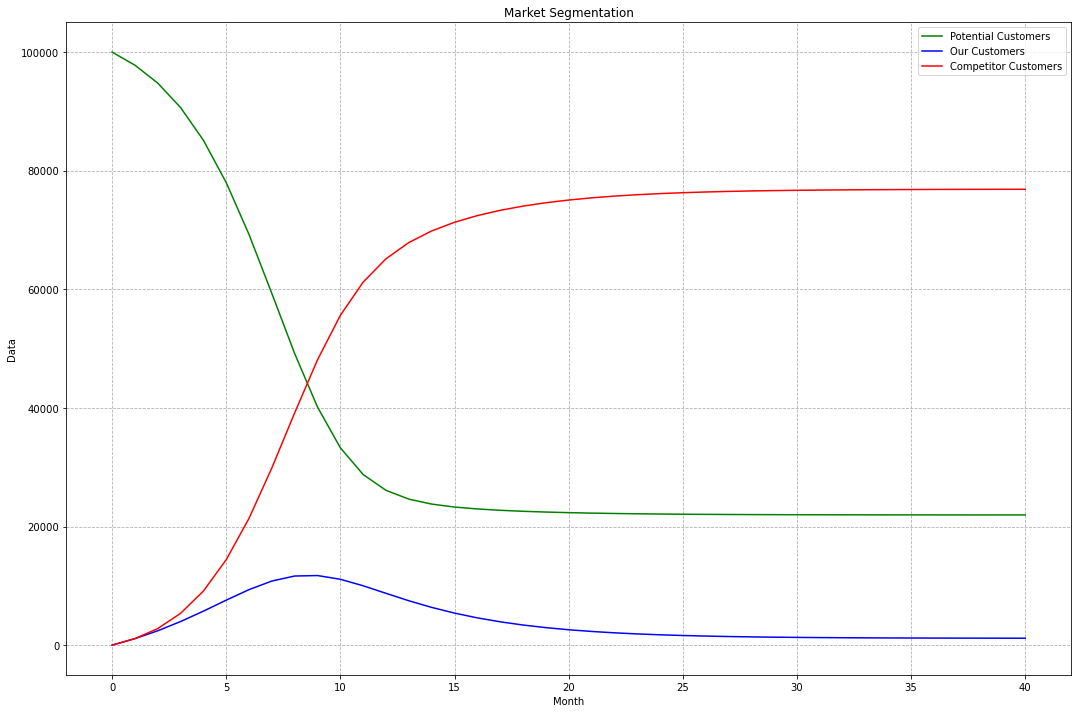

In [7]:
config = {
    "final_time": 40,
    "p11": 0.3,
    "p13": 0.5,
    "p21": 0.5,
    "p23": 0.4,
    "efficiency_word_of_mouth": 0.015,
    "efficiency_marketing": 0.011,
    "sociability": 100
}


values = run_model(model, params=config)
plot_chart(values)

### 2. Convergence Estimation

For a given task I propose the following formulation of a convergence: the observations $X=\{x_0..x_T \}$ said to converge in time moment $T$ iff $|x_T-x_i| < \epsilon$ for $i \in [1..5]$ and $\epsilon =0.05$.


Let number of customers of our company is a function $O(t)$ defined on $t \in [0, \infty]$. Similarly, number of potential customers is $P(t)$, and competitor customers $C(t)$. Thus, a given Bass model is said to be in equilibrium in time moment $T$ iff all $O(T)$, $P(t)$, and $C(t)$ converge. Let also number of customers in our and competitor company at time moment $T$ by $O(T)=M_1$ and $C(t)=M_2$.


The following cells implement this definition.

In [8]:
def get_equilibrium(values, eps=5e-1):
    """
    Method that computes market segmentation for a given model run.
    The observations are said to converge at time T iff |x_T - x_i| < eps
    for i ∈ [1..5]. Resultant values M1, M2 are values of columns 'Our Customers'
    and 'Competitor Customers' at time moment T. If the convergence test failed, 
    then it returns (None, None).

    :param values: dataframe (output of run)
    :param eps: epsilon value
    :return: M1, M2
    """
    labels = ['Potential Customers', 'Our Customers', 'Competitor Customers']
    new_labels = []
    new_values = values.copy()
    for label in labels:
        for offset in range(1, 6):
            new_label = f"{label} - {offset}"
            new_labels.append(new_label)
            new_values[new_label] = values[label].diff(periods=offset).abs()
    diffs = new_values[new_labels]
    converged = values[(diffs < eps).all(axis='columns')]
    if converged.empty:
        return None, None
    M1, M2 = converged[labels[1:]].iloc[0]
    return M1, M2


In [9]:
def simulate(p11, p13, p21, p23, final_time=1000):
    """
    Method that runs simulation with given values 
    of P11, P13, P21, and P23. 

    :param p11: P11
    :param p13: P13
    :param p21: P21
    :param p23: P23
    :param final_time: simulation time
    :return: M1, M2
    """
    config = {
        "final_time": final_time,
        "p11": p11,
        "p13": p13,
        "p21": p21,
        "p23": p23,
        "efficiency_word_of_mouth": 0.015,
        "efficiency_marketing": 0.011,
        "sociability": 100
    }
    values = run_model(model, params=config)
    equilibrium = get_equilibrium(values)
    return np.array(equilibrium)

In [10]:
simulate(p11=0.3, p13=0.5, p21=0.5, p23=0.4)

array([ 1154.22876465, 76893.42423312])

### 3. Data Preparation

Generally, the simulation models are way too slow for real-time operations, so it became a common practice to use another method (e.g. neural network) to approximate the state of a simulation. This section is devoted to composing a market segmentation dataset for this "another method".


Predictors in this dataset are $P_{11}$, $P_{13}$, $P_{21}$, and $P_{23}$ subject to $P_{11} + P_{13} \leq 1$, $P_{21} + P_{23} \leq 1$. Since we are given with a continuous space, it makes sense to discretize this space in the form of uniform grid. Uniform nature of this grid is a natural choice and subject to further study. Targets in the dataset will be market segmentation $M_1$ and $M_2$ to which the simulation converged.

In [11]:
def simulate_wrapper(args):
    """
    Wrapper for simulate method. Used to run simulations
    in parallel.

    :return: M1, M2
    """
    return simulate(*args)

In [12]:
def generate_grid(step=0.1, preferences=None):
    """
    Method that generates a grid of P11, P13, P21, P23. Can forced to compute
    the grid within a certain interval for each P.

    :param step: grid size
    :param preferences: list of lists of elements with two items: lower and upper bound for P
    :return: dataframe 
    """
    if preferences is None:
        preferences = [[0, 1]] * 4
    preferences = np.array(preferences)
    assert preferences.shape == (4, 2), "Preferences is list of list of elements with two items: lower and upper bound for P"
    space = [np.arange(pref[0], pref[1] + step, step) for pref in preferences]
    grid = np.array(np.meshgrid(*space, indexing='ij')).T.reshape(-1, 4)
    labels =  ["P11", "P13", "P21", "P23", "S1", "S2"]
    df = pd.DataFrame(data=grid, columns=labels[:4])
    temp = pd.DataFrame(data=np.zeros((len(df), 2)), columns=labels[4:])
    for idx, label in enumerate(labels[4:]):
        temp[label] = df[labels[idx * 2]] + df[labels[idx * 2 + 1]]
    df = df[(temp <= 1.).all(axis='columns')].reset_index(drop=True)
    return df

In [13]:
def get_mapping(df):
    """
    Method that computes equilibrium of a system with a given
    set of P11, P13, P21, P23. Uses multiple processes to increase
    the speed.

    :param df: dataframe with predictors
    :return: ground truth
    """
    work = [[r["P11"], r["P13"], r["P21"], r["P23"]] for _, r in df.iterrows()]
    with Pool(max(os.cpu_count() - 1, 1)) as p:
        ground_truth = list(tqdm(p.imap(simulate_wrapper, work), total=len(work)))
    targets = pd.DataFrame(data=ground_truth, columns=["M1", "M2"])
    return targets

In [14]:
def export(df, flag):
    """
    Method that saves dataframe as a csv file.

    :param df: dataframe to be saved
    :param flag: flag whether it should be saved
    :return: True if save successfully
    """
    if not flag:
        return
    if not os.path.exists('./data'):
        os.makedirs('./data')
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    filepath = os.path.join('./data', f'train | {timestamp}.csv')
    df.to_csv(filepath)
    return True

In [15]:
def compose_dataset(step=0.1, preferences=None, save=True):
    """
    Method that assembles dataset.

    :param step: grid size
    :param preferences: list of lists of elements with two items: lower and upper bound for P
    :param save: flag whether the result should be saved
    :return: dataframe 
    """
    df = generate_grid(step=step, preferences=preferences)
    targets = get_mapping(df)
    dataset = pd.concat([df, targets], axis=1).fillna(value=np.nan)
    export(dataset, save)        
    return dataset


Because of unstable behaviour of the function in extremal points 0 and 1, let's consider each of $P_{11}$, $P_{13}$, $P_{21}$, and $P_{23}$ in the range of $[ 0.1, 0.9 ]$. This phenomenon was found emperically: it turns out that model with boundary value parameters takes too much time (more than 1000 months in simulation scale) to converge.

In [16]:
preferences = [[0.1, 0.9]] * 4
df = compose_dataset(step=0.05, preferences=preferences)

100%|██████████| 18496/18496 [57:38<00:00,  5.35it/s] 


In [88]:
df = pd.read_csv("./data/train.csv", index_col=[0])

Now we are lucky owners of a dataset in first (kinda rough) approximation. Let's fix the market strategy of a competitor $P_{21}$, $P_{23}$ and visulize our market share for different combinations of $P_{11}$ and $P_{13}$.

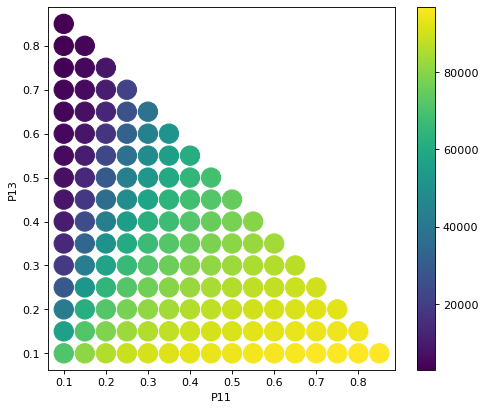

In [17]:
from matplotlib.pyplot import figure

def visualize(dataset, competitor_strategy, tol=1e-5):
    """
    Method that generates colored map of market segmentation
    for each pair P11 and P13.

    :param dataset: dataframe with values of P and M
    :param competitor_strategy: P21 and P23
    :param tol: tolerance in float poat computing
    """
    p21, p23 = competitor_strategy
    data = dataset[(abs(dataset["P21"] - p21) < tol) & (abs(dataset["P23"] - p23) < tol)]
    figure(figsize=(7, 6), dpi=80)
    plt.scatter(data["P11"], data["P13"], c=data["M1"], s=300)
    plt.xlabel("P11")
    plt.ylabel("P13")
    plt.colorbar()
    
visualize(df, [0.1, 0.3])

### 4. Machine Learning Model (1-st approximation)

To approximate the results of simulation given by a dataset there will be used Multi-Layer Perceptron (MLP).

Summary of this section is as follows:
1. Model is implemented in PyTorch.
2. MLP consists of $6$ layers. Hidden layer size is $256$.
3. Created dataset class `BassDataset` to efficiently manipulate the training data.
4. Number of epochs is set to $200$.
5. One Cycle LR by Leslie Smith is used as a learning rate scheduler. Maximal learning rate is set to be $0.1$.
6. Regularization is done with a weight decay of $0.0005$.
7. Final Mean Squared Error per sample is $51352.23$. Accordingly, the $MAE$ is $226.57$ or, taking into account maximal population of $100000$, is $\approx 0.2 \%$,

In [89]:
df.dropna(inplace=True)

In [19]:
config = {
    "Epochs": 200,
    "Layers": [4, 256, 256, 256, 256, 2],
    "Learning rate": 1e-1,
    "Weight decay": 5e-4,
    "Batch size": 150,
    "Num workers": 4,
    "Device": "cuda"  
}

In [20]:
class BassDataset(Dataset):
    """
    Dataset of a Bass model simulation results.
    """

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        X = item[["P11", "P13", "P21", "P23"]].to_numpy()
        y = item[["M1", "M2"]].to_numpy()
        
        X = torch.tensor(X)
        y = torch.tensor(y)
        return X, y

In [21]:
trainset = BassDataset(df)
trainloader = DataLoader(trainset, batch_size=config["Batch size"], shuffle=False, num_workers=config["Num workers"])

In [22]:
class Block(nn.Module):
    """
    Class combining linear layer and activation.
    """
    def __init__(self, input_dim, output_dim, activation):
        super(Block, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            activation()
        )
        
    def forward(self, x):
        out = self.main(x)
        return out


class MLP(nn.Module):
    """
    Class representing Multi-Layer Perceptron (MLP).
    Uses instances of a Block class for a hidden layers. 
    """

    def __init__(self, layers, activation=nn.ReLU):
        super(MLP, self).__init__()
        self.layers = layers
        self.activation = activation
        self.main = self.__init_model(layers)
    
    def __init_model(self, layers):
        sequence = []
        for idx in range(len(layers) - 2):
            layer = Block(layers[idx], layers[idx + 1], self.activation)
            sequence.append(layer)
        sequence.append(nn.Linear(layers[-2], layers[-1], self.activation))
        return torch.nn.Sequential(*sequence)
    
    def forward(self, x):
        out = self.main(x)
        return out

In [23]:
def make():
    """
    Method constructing model, optimizer, scheduler and criterion.
    """
    model = MLP(config["Layers"])
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["Learning rate"], weight_decay=config["Weight decay"])
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, config["Learning rate"], config['Epochs'], steps_per_epoch=len(trainloader))
    criterion = nn.MSELoss()
    return model, optimizer, scheduler, criterion

In [24]:
def train(model, criterion, loader, optimizer):
    """
    Training routine for the model. Iterates over the elements in the loader.
    Uses criterion to calculate the loss. Applies optimizer to update weights.
    :param model: PyTorch model
    :param criterion: method computing the loss 
    :param loader: dataloader
    :param optimizer: optimization algorithm
    :return: per batch loss, average balanced accuracy
    """
    model.to(config['Device'])
    model.train()
    
    train_loss = 0.0
    for _, (X, y) in enumerate(loader):
        X, y = X.to(config['Device']).float(), y.to(config['Device']).float()
        optimizer.zero_grad()
        predictions = model(X)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    return train_loss / len(loader.dataset)

In [25]:
def pipeline():
    """
    Method that implements the main flow of a model.
    """
    model, optimizer, scheduler, criterion = make()
    losses = {'train': []}

    for epoch in range(config['Epochs']):  
        train_loss = train(model, criterion, trainloader, optimizer)
        scheduler.step()
        
        losses['train'].append(train_loss)
        print(f"Epoch: {epoch+1:02d} | Train loss: {train_loss:.5f}")

        if train_loss <= min(losses['train']):
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss, 
            }, os.path.join("weights", f"{epoch}.pt"))
    return losses

In [26]:
losses = pipeline()

Epoch: 01 | Train loss: 13588025.32305
Epoch: 02 | Train loss: 12271083.55739
Epoch: 03 | Train loss: 11270293.00901
Epoch: 04 | Train loss: 11034533.60495
Epoch: 05 | Train loss: 10951741.58497
Epoch: 06 | Train loss: 10915417.13020
Epoch: 07 | Train loss: 10928740.06906
Epoch: 08 | Train loss: 10958218.01803
Epoch: 09 | Train loss: 11002121.71224
Epoch: 10 | Train loss: 11086152.66978
Epoch: 11 | Train loss: 11151833.17885
Epoch: 12 | Train loss: 11122086.66652
Epoch: 13 | Train loss: 11608724.20979
Epoch: 14 | Train loss: 11350499.72158
Epoch: 15 | Train loss: 11125035.98827
Epoch: 16 | Train loss: 10930940.77446
Epoch: 17 | Train loss: 5968472.84526
Epoch: 18 | Train loss: 1705406.56016
Epoch: 19 | Train loss: 1534900.85275
Epoch: 20 | Train loss: 1189240.94858
Epoch: 21 | Train loss: 986159.49723
Epoch: 22 | Train loss: 873654.73979
Epoch: 23 | Train loss: 994473.56735
Epoch: 24 | Train loss: 587666.28510
Epoch: 25 | Train loss: 1237684.71577
Epoch: 26 | Train loss: 969583.81458
E

In [27]:
def visualize_loss(losses):
    """
    Method used to visualize the behaviour of losses over the time.
    :param losses: dict with keys 'train', 'test' and values - losses.
    :param accuracies: dict with keys 'train', 'test' and values - balanced accuracies.
    """
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(12, 8)
    ax1.set_title(f"Comparison of losses")
    ax1.grid(linestyle='--')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(np.arange(len(losses['train'])), np.array(losses['train']), '-', label='Train', c='b')
    ax1.legend()

    plt.show() 

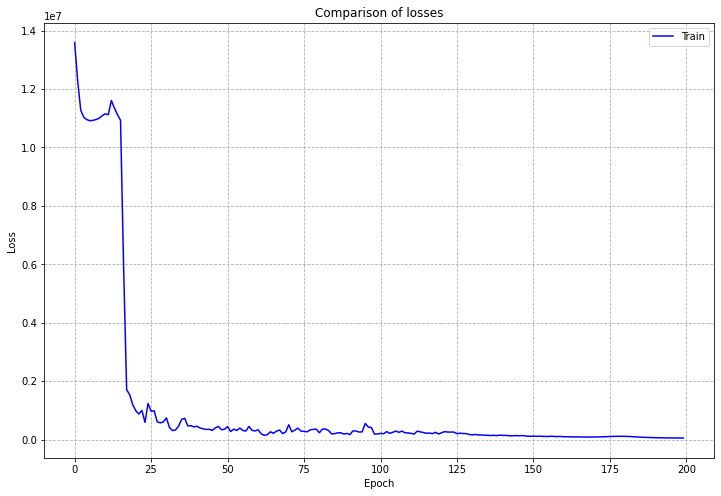

In [28]:
visualize_loss(losses)

In [29]:
checkpoint = torch.load(os.path.join("weights", "199.pt"))
inferenced = MLP(config["Layers"]).double()
inferenced.load_state_dict(checkpoint['model_state_dict'])
inferenced.eval()

MLP(
  (main): Sequential(
    (0): BlockAE(
      (main): Sequential(
        (0): Linear(in_features=4, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (1): BlockAE(
      (main): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (2): BlockAE(
      (main): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (3): BlockAE(
      (main): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

Let's check whether the inferenced model works fine for some arbitrary values.

In [78]:
combination = [0.16, 0.42, 0.42, 0.23]
tol = 1e-5
values = df[(abs(df["P11"] - combination[0]) < tol) & (abs(df["P13"] - combination[1]) < tol) & (abs(df["P21"] - combination[2]) < tol) & (abs(df["P23"] - combination[3]) < tol)]

print(f"Prediction: M1 = {inferenced(torch.tensor(combination).double())[0]:.4f} M2 = {inferenced(torch.tensor(combination).double())[1]:.4f}")

Prediction: M1 = 3332.0255 M2 = 71161.0251


### 5. Choosing market strategy

For example, I am curious about the case when competitor's parameters $P_{21}=0.1$, $P_{23}=0.1$, and parameters of our company are $P_{11}=0.15$, $P_{13}=0.1$, so that we slightly outperform the competitor in number of satisfied customers. Let's find the market segmentation using the ML model in this case.

In [90]:
p11, p13, p21, p23 = 0.15, 0.1, 0.1, 0.1

In [91]:
def get_snapshot(df):
    data = df[(abs(df["P21"] - p21) < tol) & (abs(df["P23"] - p23) < tol)]
    data["M1 (pred.)"] = data.apply(lambda x: inferenced(torch.tensor([x['P11'], x['P13'], x['P21'], x['P23']]).double()).detach().numpy()[0], axis=1)
    data["M2 (pred.)"] = data.apply(lambda x: inferenced(torch.tensor([x['P11'], x['P13'], x['P21'], x['P23']]).double()).detach().numpy()[1], axis=1)
    return data

In [92]:
data = get_snapshot(df)

In [93]:
def get_market_seg(data, tol=1e-5, total=1e5):
    _M1, _M2 = data[(abs(data["P11"] - p11) < tol) & (abs(data["P13"] - p13) < tol)].reset_index().iloc[0][["M1 (pred.)", "M2 (pred.)"]]
    return _M1, _M2

In [96]:
M1, M2 = get_market_seg(data)
print(f"M1 = {M1} M2 = {M2}")

M1 = 80524.99793966554 M2 = 2761.025290603635


The market segmentation for our case is $M_1=80524.998$ and $M_2=2761.025$. So, let's observe all $P_{11}$, $P_{13}$ that give same market segmentation (again based on results of ML model). It is worth mentioning that we are interested in all combinations $P_{11}$, $P_{13}$ with $7\%$ deviation from the desired market segmentation.

In [95]:
TOTAL = 1e5
data[(abs(data["M1 (pred.)"] - M1) / TOTAL < 0.07) & (abs(data["M2 (pred.)"] - M2) / TOTAL  < 0.07)]

,P11,P13,P21,P23,M1,M2,M1 (pred.),M2 (pred.)
1,0.15,0.10,0.1,0.1,79158.334694,3788.763675,80524.997940,2761.025291
2,0.20,0.10,0.1,0.1,85342.003277,1545.490515,85666.715149,1012.632359
18,0.20,0.15,0.1,0.1,77817.474890,2711.416121,78037.457893,1922.060100
19,0.25,0.15,0.1,0.1,82695.741843,1423.003464,83028.436331,945.432225
34,0.25,0.20,0.1,0.1,76841.039261,2121.825651,75429.099388,2227.707808
35,0.30,0.20,0.1,0.1,80934.815347,1281.034900,80277.539274,1290.746551
36,0.35,0.20,0.1,0.1,83750.327865,864.449028,84956.232708,827.709975
37,0.40,0.20,0.1,0.1,85824.565219,625.090980,86410.700238,733.414964
38,0.45,0.20,0.1,0.1,87422.219030,474.015038,86803.564281,707.294725
39,0.50,0.20,0.1,0.1,88692.850760,372.248704,87196.428324,681.174487


From this entire list let's choose another combination $\hat{P_{11}}=0.5$ and $\hat{P_{13}}=0.35$. This pair along with original $P_{11}=0.15$, $P_{13}=0.1$, will be examined on higher resolution grid. Let's create another training dataset with a lower step size of $0.01$.

In [56]:
preferences = [[0, 0.6], [0, 0.6], [0.1, 0.1], [0.1, 0.1]]
compose_dataset(step=0.01, preferences=preferences)

100%|██████████| 3511/3511 [11:38<00:00,  5.03it/s]


,P11,P13,P21,P23,M1,M2
0,0.00,0.0,0.1,0.1,4117.716023,72426.985784
1,0.01,0.0,0.1,0.1,4860.916936,71846.548991
2,0.02,0.0,0.1,0.1,5933.086429,71009.585813
3,0.03,0.0,0.1,0.1,7616.659164,69696.333026
4,0.04,0.0,0.1,0.1,10655.522992,67328.969207
...,...,...,...,...,...,...
3506,0.36,0.6,0.1,0.1,51959.966149,4807.524759
3507,0.37,0.6,0.1,0.1,53405.648569,4302.128129
3508,0.38,0.6,0.1,0.1,54748.125642,3879.707754
3509,0.39,0.6,0.1,0.1,56001.707982,3521.807218


In [100]:
roi = pd.read_csv("./data/region of interest.csv", index_col=[0])
roi.dropna(inplace=True)

### 6. Machine Learning Model (2-nd approximation)

Let's once again train MLP, but on the later dataset.

In [68]:
trainset = BassDataset(roi)
trainloader = DataLoader(trainset, batch_size=config["Batch size"], shuffle=False, num_workers=config["Num workers"])

In [71]:
config = {
    "Epochs": 400,
    "Layers": [4, 256, 256, 256, 256, 2],
    "Learning rate": 1e-1,
    "Weight decay": 5e-4,
    "Batch size": 150,
    "Num workers": 4,
    "Device": "cuda"  
}

In [72]:
losses = pipeline()

Epoch: 01 | Train loss: 34737159.69389
Epoch: 02 | Train loss: 17134458.11536
Epoch: 03 | Train loss: 16461621.03484
Epoch: 04 | Train loss: 16538920.60765
Epoch: 05 | Train loss: 15727903.74415
Epoch: 06 | Train loss: 14307909.84809
Epoch: 07 | Train loss: 12696873.59452
Epoch: 08 | Train loss: 11847322.26156
Epoch: 09 | Train loss: 11542895.39692
Epoch: 10 | Train loss: 11400162.00114
Epoch: 11 | Train loss: 11260991.57053
Epoch: 12 | Train loss: 11136891.72359
Epoch: 13 | Train loss: 10980976.03655
Epoch: 14 | Train loss: 10884832.91376
Epoch: 15 | Train loss: 10340384.93204
Epoch: 16 | Train loss: 2712329.95031
Epoch: 17 | Train loss: 720446.17076
Epoch: 18 | Train loss: 742408.72937
Epoch: 19 | Train loss: 787742.92397
Epoch: 20 | Train loss: 641045.19439
Epoch: 21 | Train loss: 138253.01874
Epoch: 22 | Train loss: 363612.05340
Epoch: 23 | Train loss: 158970.46823
Epoch: 24 | Train loss: 122539.29165
Epoch: 25 | Train loss: 167059.63453
Epoch: 26 | Train loss: 202065.47437
Epoch: 

In [107]:
checkpoint = torch.load(os.path.join("weights", "399.pt"))
inferenced = MLP(config["Layers"]).double()
inferenced.load_state_dict(checkpoint['model_state_dict'])
inferenced.eval()

MLP(
  (main): Sequential(
    (0): BlockAE(
      (main): Sequential(
        (0): Linear(in_features=4, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (1): BlockAE(
      (main): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (2): BlockAE(
      (main): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (3): BlockAE(
      (main): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [109]:
def apply_model(df):
    new_data = df.copy()
    new_data["M1 (pred.)"] = new_data.apply(lambda x: inferenced(torch.tensor([x['P11'], x['P13'], x['P21'], x['P23']]).double()).detach().numpy()[0], axis=1)
    new_data["M2 (pred.)"] = new_data.apply(lambda x: inferenced(torch.tensor([x['P11'], x['P13'], x['P21'], x['P23']]).double()).detach().numpy()[1], axis=1)
    return new_data

In [110]:
second_approximation = apply_model(roi)

In [111]:
def select_area(df, M1, M2):
    return df[(abs(df["M1 (pred.)"] - M1) / TOTAL < 0.07) & (abs(df["M2 (pred.)"] - M2) / TOTAL < 0.07)]


In [112]:
areas = select_area(second_approximation, M1, M2)

In [124]:
def visualize_areas(areas):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_title(f"Region of freedom")
    ax1.grid(linestyle='--')
    ax1.set_xlabel('P11')
    ax1.set_ylabel('P13')
    ax1.set_xlim((0, 1))
    ax1.set_ylim((0, 1))
    ax1.scatter(areas["P11"], areas["P13"], label='Freedom', c='g')
    ax1.legend()

    plt.show() 

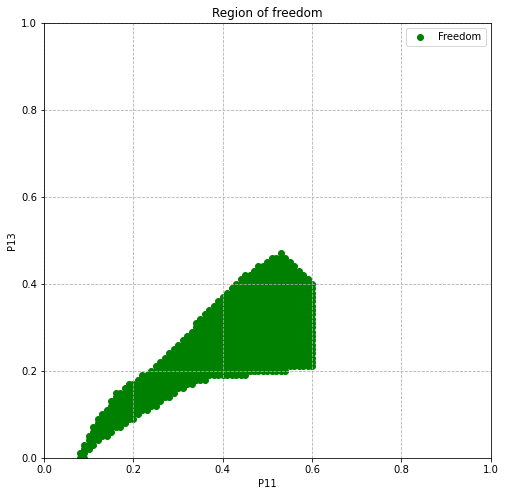

In [126]:
visualize_areas(areas)